In [1]:
import torch
import collections
import math

def ngrams_iterator(token_list, ngrams):
    """Return an iterator that yields the given tokens and their ngrams.

    Args:
        token_list: A list of tokens
        ngrams: the number of ngrams.

    Examples:
        >>> token_list = ['here', 'we', 'are']
        >>> list(ngrams_iterator(token_list, 2))
        >>> ['here', 'here we', 'we', 'we are', 'are']
    """

    def _get_ngrams(n):
        return zip(*[token_list[i:] for i in range(n)])

    for x in token_list:
        yield x
    for n in range(2, ngrams + 1):
        for x in _get_ngrams(n):
            yield " ".join(x)

def _compute_ngram_counter(tokens, max_n):
    """Create a Counter with a count of unique n-grams in the tokens list

    Args:
        tokens: a list of tokens (typically a string split on whitespaces)
        max_n: the maximum order of n-gram wanted

    Outputs:
        output: a collections.Counter object with the unique n-grams and their
            associated count

    Examples:
        >>> from torchtext.data.metrics import _compute_ngram_counter
        >>> tokens = ['me', 'me', 'you']
        >>> _compute_ngram_counter(tokens, 2)
            Counter({('me',): 2,
             ('you',): 1,
             ('me', 'me'): 1,
             ('me', 'you'): 1})
    """
    assert max_n > 0
    ngrams_counter = collections.Counter(tuple(x.split(" ")) for x in ngrams_iterator(tokens, max_n))

    return ngrams_counter

def bleu_score(candidate_corpus, references_corpus, max_n=4, weights=[0.25] * 4):
    """Computes the BLEU score between a candidate translation corpus and a references
    translation corpus. Based on https://www.aclweb.org/anthology/P02-1040.pdf

    Args:
        candidate_corpus: an iterable of candidate translations. Each translation is an
            iterable of tokens
        references_corpus: an iterable of iterables of reference translations. Each
            translation is an iterable of tokens
        max_n: the maximum n-gram we want to use. E.g. if max_n=3, we will use unigrams,
            bigrams and trigrams
        weights: a list of weights used for each n-gram category (uniform by default)

    Examples:
        >>> from torchtext.data.metrics import bleu_score
        >>> candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
        >>> references_corpus = [[['My', 'full', 'pytorch', 'test'], ['Completely', 'Different']], [['No', 'Match']]]
        >>> bleu_score(candidate_corpus, references_corpus)
            0.8408964276313782
    """

    assert max_n == len(weights), 'Length of the "weights" list has be equal to max_n'
    assert len(candidate_corpus) == len(
        references_corpus
    ), "The length of candidate and reference corpus should be the same"

    clipped_counts = torch.zeros(max_n)
    total_counts = torch.zeros(max_n)
    weights = torch.tensor(weights)

    candidate_len = 0.0
    refs_len = 0.0

    for (candidate, refs) in zip(candidate_corpus, references_corpus):
        current_candidate_len = len(candidate)
        candidate_len += current_candidate_len

        # Get the length of the reference that's closest in length to the candidate
        refs_len_list = [float(len(ref)) for ref in refs]
        refs_len += min(refs_len_list, key=lambda x: abs(current_candidate_len - x))

        reference_counters = _compute_ngram_counter(refs[0], max_n)
        for ref in refs[1:]:
            reference_counters = reference_counters | _compute_ngram_counter(ref, max_n)

        candidate_counter = _compute_ngram_counter(candidate, max_n)

        clipped_counter = candidate_counter & reference_counters

        for ngram, count in clipped_counter.items():
            clipped_counts[len(ngram) - 1] += count

        for i in range(max_n):
            # The number of N-grams in a `candidate` of T tokens is `T - (N - 1)`
            total_counts[i] += max(current_candidate_len - i, 0)

    if min(clipped_counts) == 0:
        return 0.0
    else:
        pn = clipped_counts / total_counts
        log_pn = weights * torch.log(pn)
        score = torch.exp(sum(log_pn))

        bp = math.exp(min(1 - refs_len / candidate_len, 0))

        return bp * score.item()

In [19]:
candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test'], ['Completely', 'Different']], [['No', 'Match']]]
bleu_score(candidate_corpus, references_corpus)

In [26]:
candidate_corpus = [['the', 'fast', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
references_corpus = [[['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]]
bleu_score(candidate_corpus, references_corpus, weights=[0.25, 0.25, 0.25, 0.25])

0.750623881816864

In [33]:
# install pytorch and huggingface transformers if you havn't done so
!pip install torch==1.5.1
!pip install transformers==3.0.1
! pip install bert_score==0.3.4
# cloning the repo because we need to get some example data
!git clone https://github.com/Tiiiger/bert_score.git

     |████████████████████████████████| 753.2 MB 23 kB/s  eta 0:00:013    |███▊                            | 86.7 MB 22.4 MB/s eta 0:00:30
ERROR: torchvision 0.16.0 has requirement torch==2.1.0, but you'll have torch 1.5.1 which is incompatible.
ERROR: textbox 0.2.1 has requirement torch>=1.6.0, but you'll have torch 1.5.1 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1
    Uninstalling torch-2.0.1:
      Successfully uninstalled torch-2.0.1
     |████████████████████████████████| 757 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 47.7 MB/s eta 0:00:01
     |████████████████████████████████| 897 kB 26.3 MB/s eta 0:00:01
ERROR: textbox 0.2.1 has requirement torch>=1.6.0, but you'll have torch 1.5.1 which is incompatible.
ERROR: textbox 0.2.1 has requirement transformers>=4.5.1, but you'll have transformers 3.0.1 which is incompatible.
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0

fatal: целевой путь «bert_score» уже существует и не является пустым каталогом.


![BERTSCORE](https://github.com/Tiiiger/bert_score/raw/master/bert_score.png)

In [4]:
from bert_score import score
from bert_score import plot_example
import matplotlib.pyplot as plt

In [2]:
with open("bert_score/example/hyps.txt") as f:
    cands = [line.strip() for line in f]

with open("bert_score/example/refs.txt") as f:
    refs = [line.strip() for line in f]

In [3]:
# When you are running this cell for the first time, 
# it will download the BERT model which will take relatively longer. 
P, R, F1 = score(cands, refs, lang="en", verbose=True)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.92 seconds, 5.21 sentences/sec


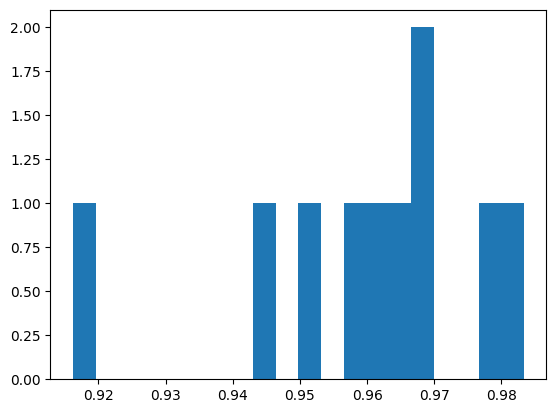

In [5]:
plt.hist(F1, bins=20)
plt.show()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

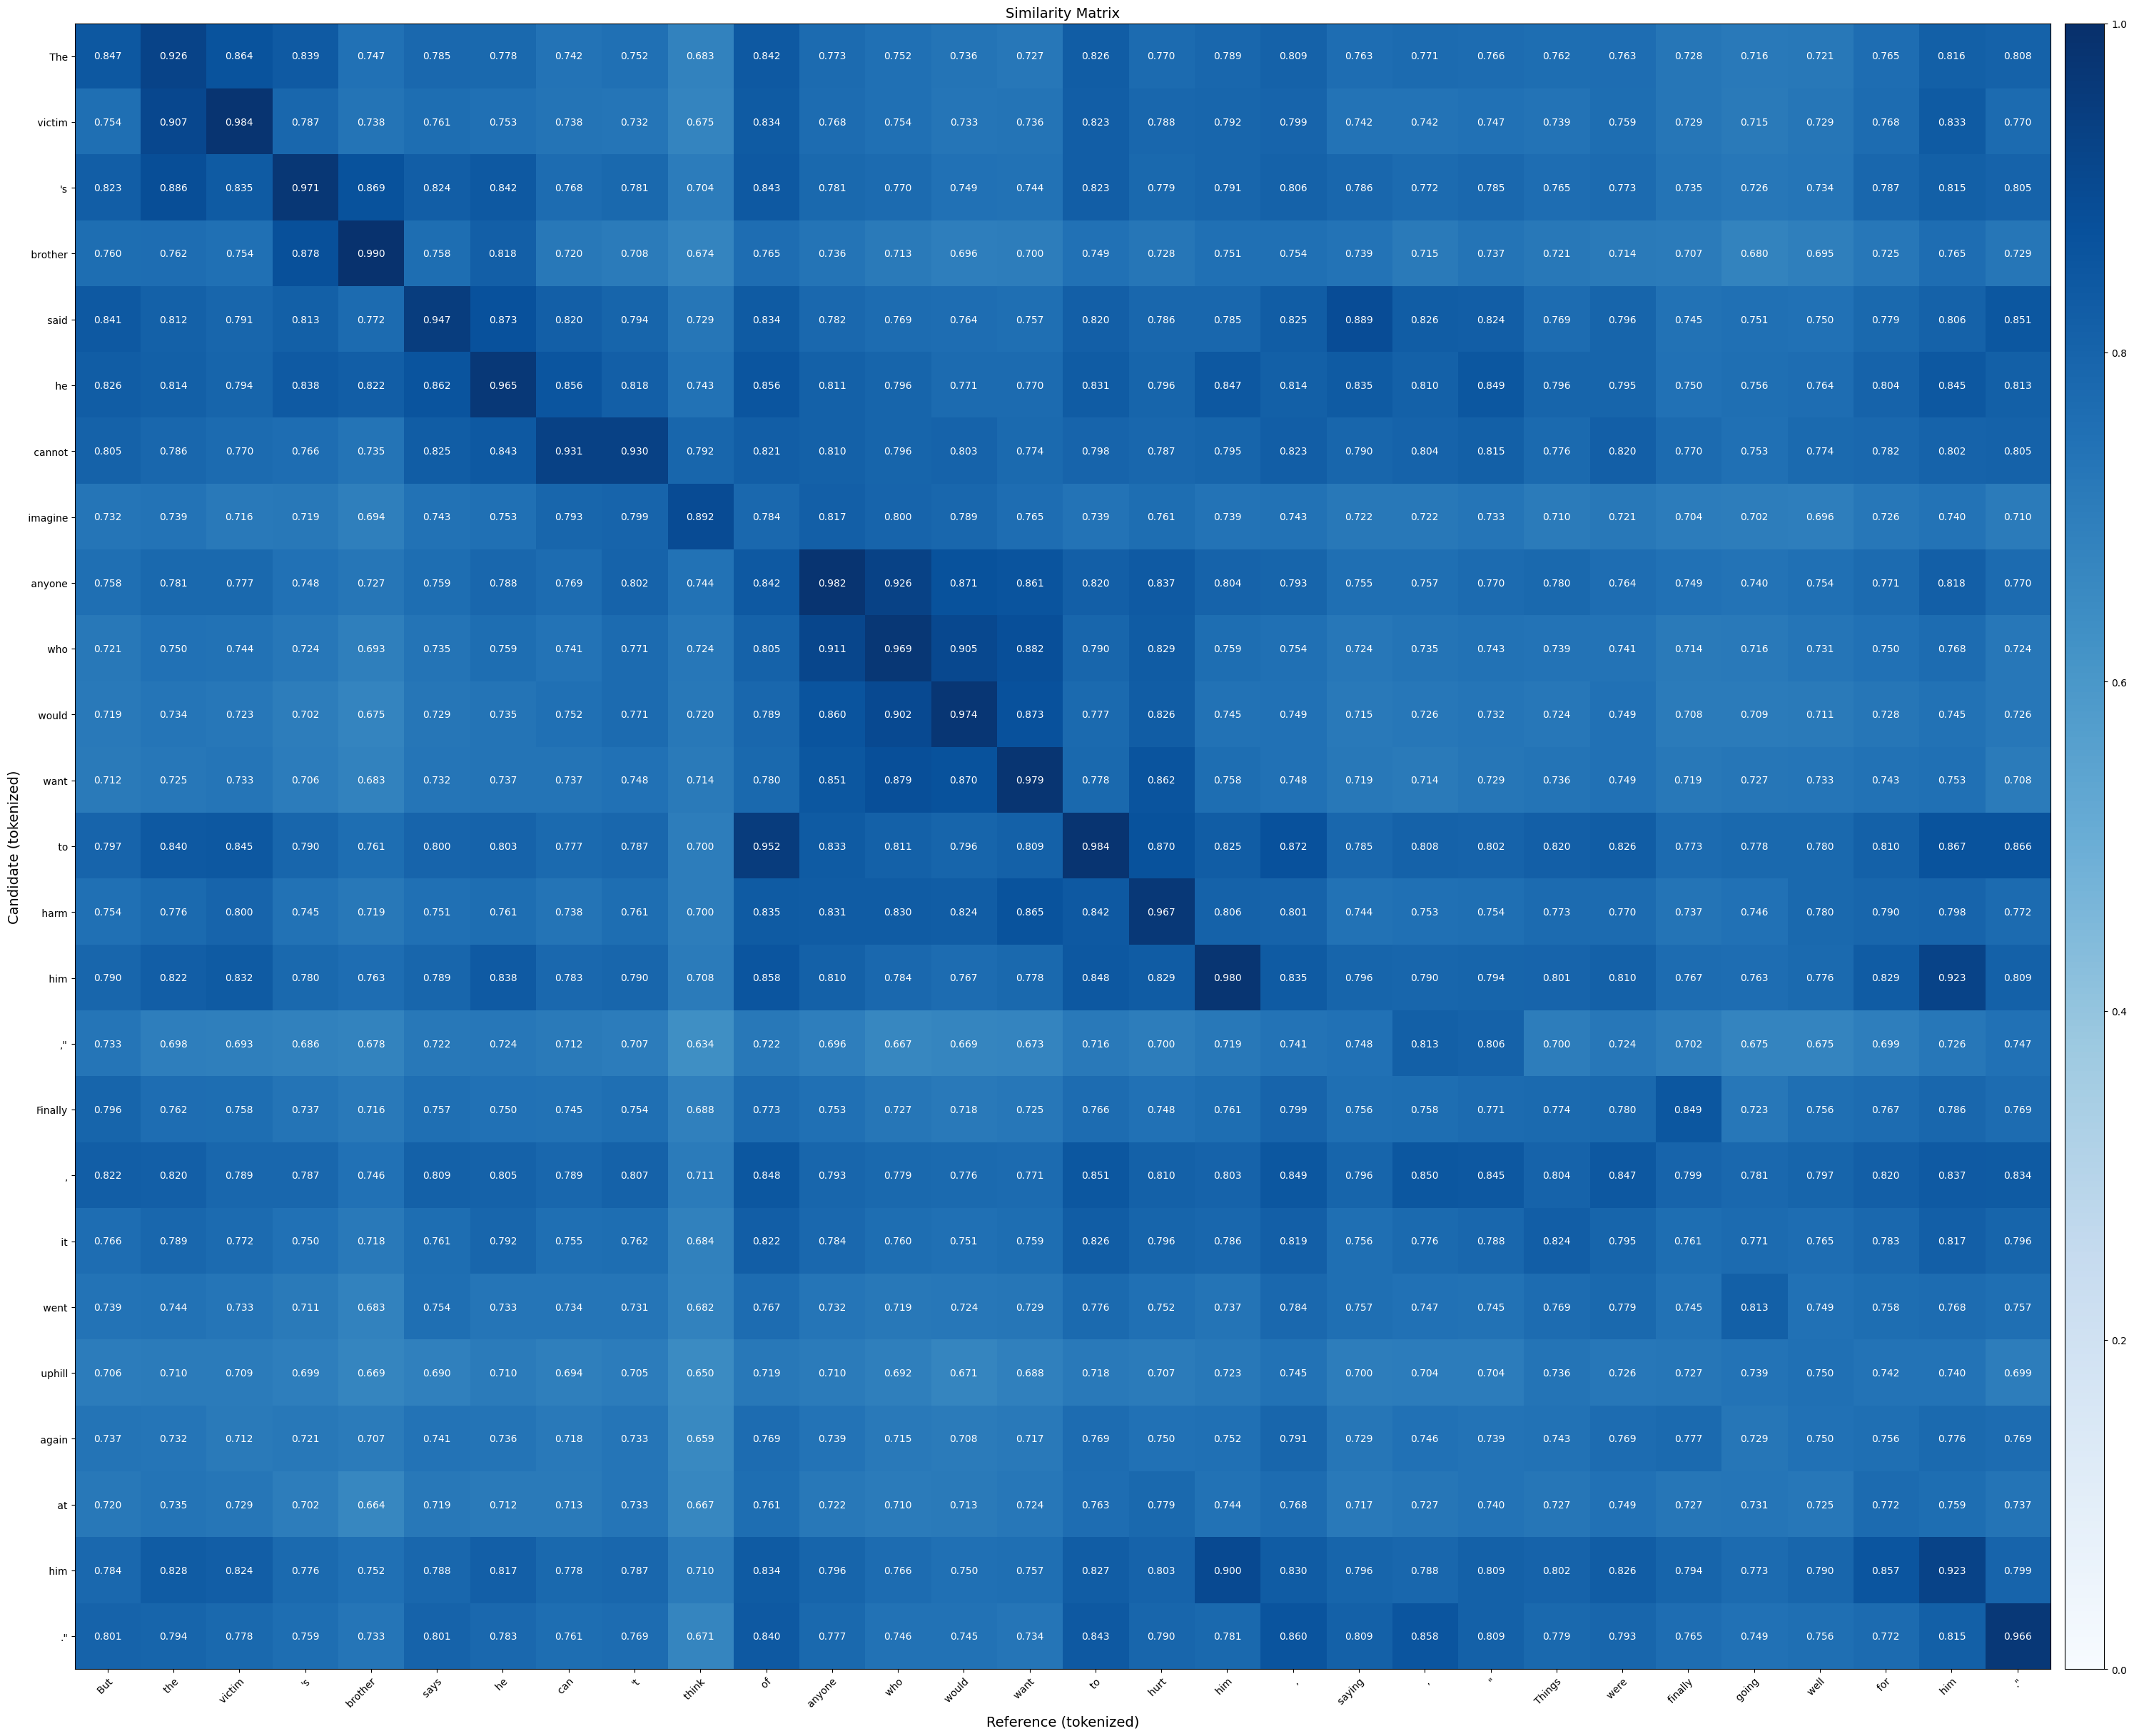

In [9]:
cand = cands[2]
ref = refs[2]
plot_example(cand, ref, lang="en")

In [12]:
# When you are running this cell for the first time, 
# it will download the BERT model which will take relatively longer. 
cands = ["And so he also gave the prize money of 25,000 euros."]
refs = ["And in this vein, he passed the prize money of 25,000 euros on straight away."]
P, R, F1 = score(cands, refs , lang="en", verbose=True)

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 4.90 sentences/sec


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

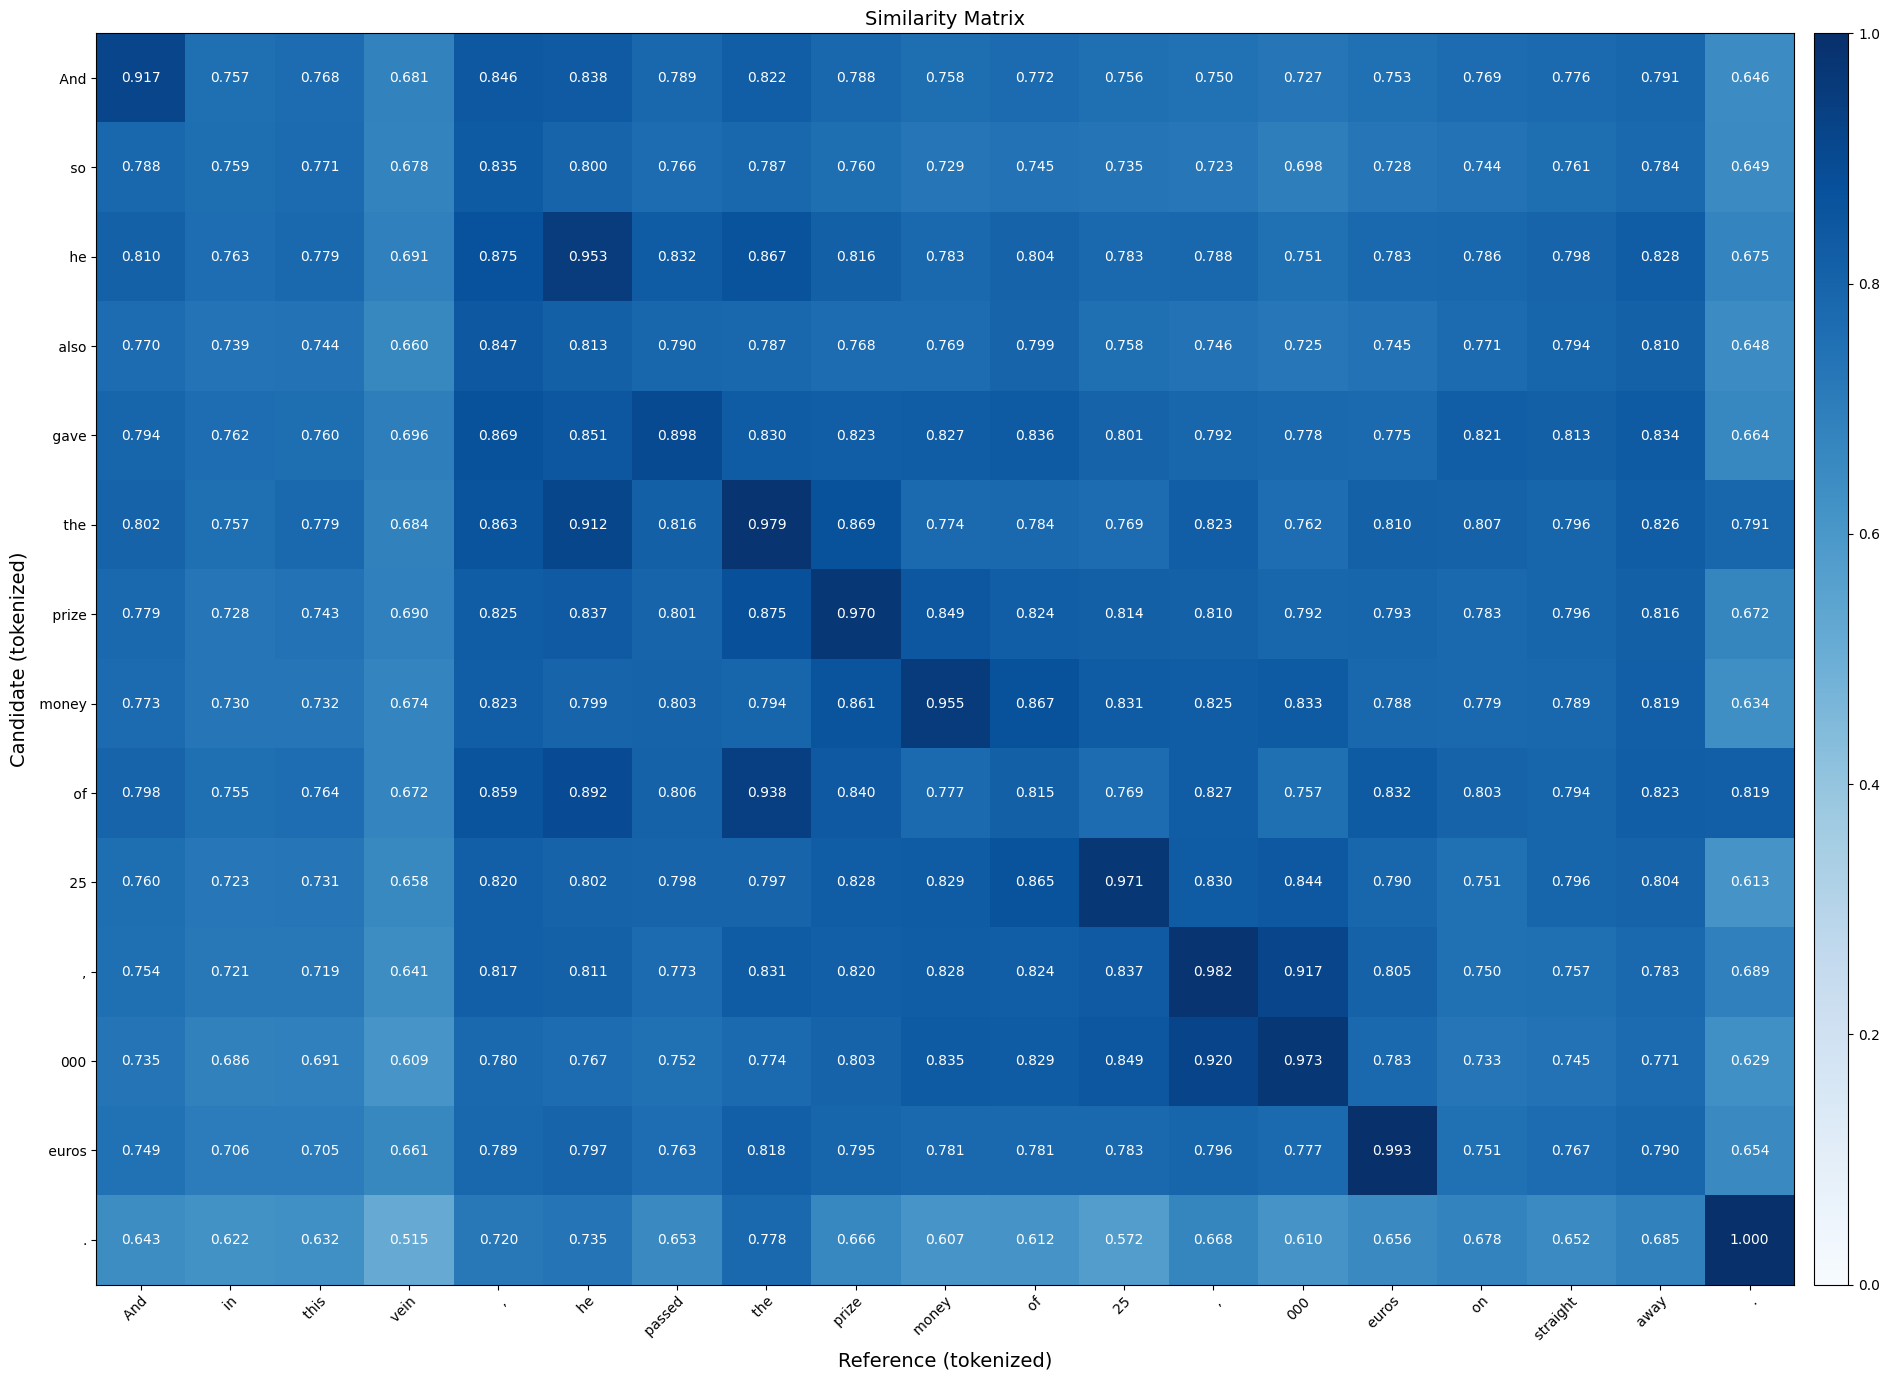

In [17]:
cand = cands[0]
ref = refs[0]
plot_example(cand, ref, lang="en")